In [1]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

import random

In [2]:
train_path = 'C:/Users/Dinny/Desktop/Diploma/Model/working/data/train'
val_path = 'C:/Users/Dinny/Desktop/Diploma/Model/working/data/val'
test_path = 'C:/Users/Dinny/Desktop/Diploma/Model/working/data/test'

In [3]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Battery: 756
Biological: 788
Cardboard: 1000
Glass: 1000
Metal: 1000
Paper: 1000
Plastic: 1000
Trash: 667

Total number of train images: 7211


In [4]:
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'glass',
 'metal',
 'paper',
 'plastic',
 'trash']

In [5]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1000, 1000, 1000, 1000, 1000, 667]

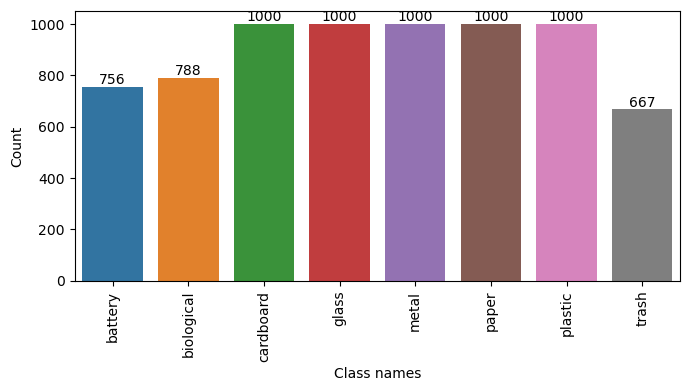

In [6]:
DF = pd.DataFrame(columns=['Class names','Count'])
DF['Class names']=class_names
DF['Count']=class_dis
plt.figure(figsize=(7,4))
ax=sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [7]:
data_path = 'C:/Users/Dinny/Desktop/Diploma/Model/working/data'

In [8]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 431.2833
Mean Height: 384.8422


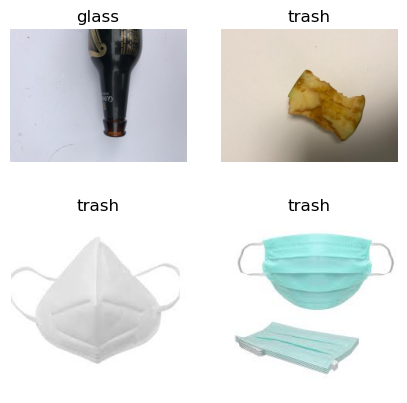

In [9]:
fig, axes = plt.subplots(2, 2, figsize = (5,5)) #выведем 4 изображения
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path)) #случайный выбор класса
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir)) #cлучайный выбор изображения из класса
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

In [10]:
IMG_SIZE = (400, 400)
BATCH_SIZE = 32
SEED = 43
torch.manual_seed(SEED)

In [11]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE[0], IMG_SIZE[1])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
train_dataset = datasets.ImageFolder(train_path, transform=transform)
val_dataset = datasets.ImageFolder(val_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle=True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = 4, shuffle=True, pin_memory = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def test_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'test_loss': loss.detach(), 'test_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def test_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [16]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(class_names))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

resnet34_model = ResNet()

C:\Users\Dinny\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Dinny\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cpu')

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
to_device(resnet34_model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [20]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return class_names[preds[0].item()]

def test(model, test_loader):
    outputs = [model.test_step(batch) for batch in test_loader]
    return model.test_epoch_end(outputs)        

def fit(epochs, lr, model, train_loader, val_loader, optimizer):
    history = []
    best_val_loss = 10
    patient = 7
   
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
                
        # Early stopping
        if result['val_loss']>= best_val_loss:
            trigger += 1
            print('Trigger time',trigger)
            if trigger > patient:
                return history, ResNet34_model
        else:
            best_val_loss = result['val_loss']
            ResNet34_model = copy.deepcopy(model)
            trigger = 0
    return history,ResNet34_model

In [21]:
model = to_device(ResNet(), device)

In [22]:
evaluate(model, val_loader)

{'val_loss': 2.0673701763153076, 'val_acc': 0.12495286762714386}

In [23]:
EPOCH=20
lr = 5.5e-5

optimizer = torch.optim.Adam(model.parameters(), lr)

history,ResNet34_model = fit(EPOCH, lr, model, train_loader, val_loader, optimizer)

Epoch 1: train_loss: 1.5135, val_loss: 1.3645, val_acc: 0.9248
Epoch 2: train_loss: 1.3429, val_loss: 1.3246, val_acc: 0.9531
Epoch 3: train_loss: 1.3082, val_loss: 1.3198, val_acc: 0.9591
Epoch 4: train_loss: 1.2976, val_loss: 1.3214, val_acc: 0.9547
Trigger time 1
Epoch 5: train_loss: 1.2892, val_loss: 1.3218, val_acc: 0.9525
Trigger time 2
Epoch 6: train_loss: 1.2875, val_loss: 1.3250, val_acc: 0.9489
Trigger time 3
Epoch 7: train_loss: 1.2856, val_loss: 1.3215, val_acc: 0.9510
Trigger time 4
Epoch 8: train_loss: 1.2842, val_loss: 1.3115, val_acc: 0.9646
Epoch 9: train_loss: 1.2830, val_loss: 1.3185, val_acc: 0.9510
Trigger time 1
Epoch 10: train_loss: 1.2843, val_loss: 1.3114, val_acc: 0.9638
Epoch 11: train_loss: 1.2800, val_loss: 1.3138, val_acc: 0.9539
Trigger time 1
Epoch 12: train_loss: 1.2820, val_loss: 1.3183, val_acc: 0.9472
Trigger time 2
Epoch 13: train_loss: 1.2783, val_loss: 1.3151, val_acc: 0.9562
Trigger time 3
Epoch 14: train_loss: 1.2780, val_loss: 1.3168, val_acc: 

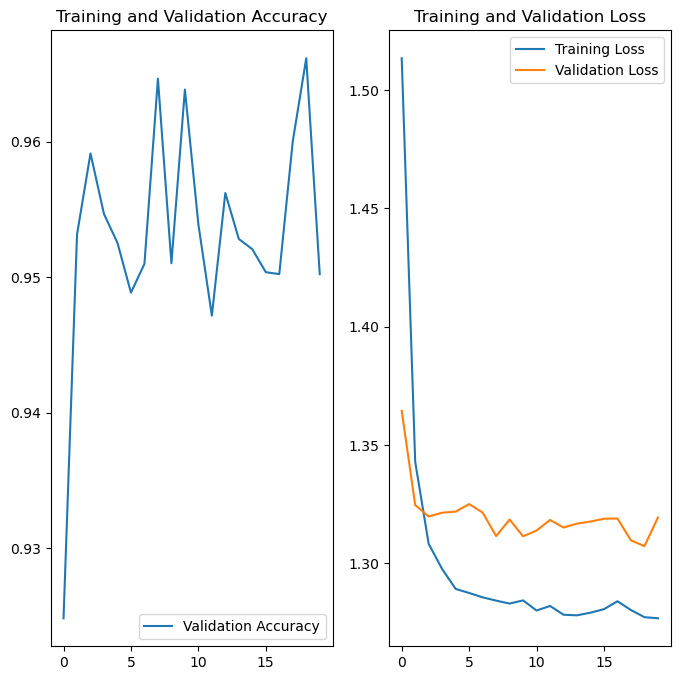

In [24]:
accuracies = [x['val_acc'] for x in history]
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
test(model, test_loader)

{'test_loss': 1.3155468702316284, 'test_acc': 0.9591346383094788}

In [26]:
preds = torch.zeros((0,8)).cpu()
labels = torch.zeros((0)).cpu()
ResNet34_model.eval()
with torch.no_grad():
    for i, (images, label) in enumerate(test_loader):
        pred = ResNet34_model(images)
        preds = torch.cat((preds,pred),dim = 0)
        labels = torch.cat((labels,label.float()))

# one hot encoding test labels
y_true = np.zeros(preds.shape)
for i in range (preds.shape[0]):
    for j in range(preds.shape[1]):
        y_true[i][j] = 1 if labels[i]== j else 0

In [27]:
_, y_pred = torch.max(preds, dim=1)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report \n')
target_names = class_names
print(classification_report(labels.cpu(), y_pred.cpu(), target_names = target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.96      0.97        95
  biological       0.96      1.00      0.98        99
   cardboard       0.98      0.97      0.97       234
       glass       0.95      0.96      0.96       409
       metal       0.91      0.97      0.94       188
       paper       0.97      0.99      0.98       272
     plastic       0.97      0.91      0.94       253
       trash       0.96      0.94      0.95        84

    accuracy                           0.96      1634
   macro avg       0.96      0.96      0.96      1634
weighted avg       0.96      0.96      0.96      1634



In [29]:
import itertools

In [30]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

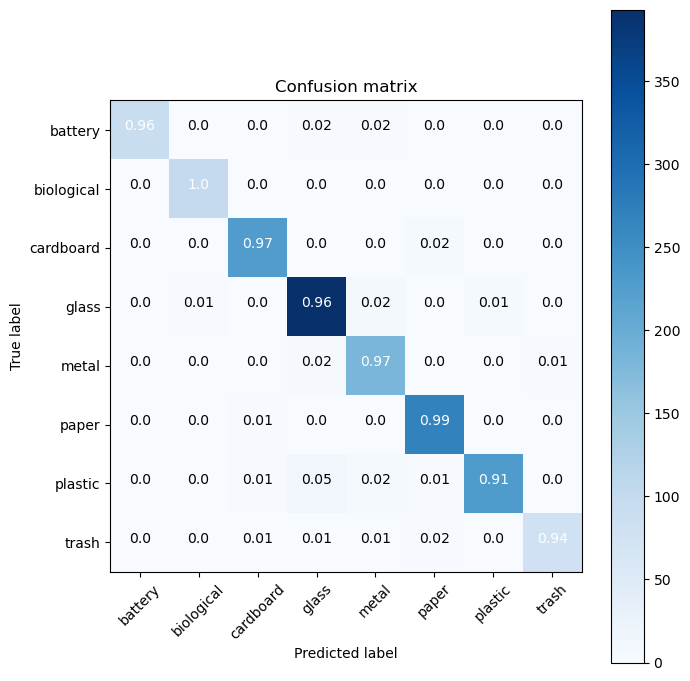

In [31]:
cm = confusion_matrix(labels.cpu(), y_pred.cpu())
plot_confusion_matrix(cm, class_names)

In [32]:
import pickle
pickle.dump(ResNet34_model ,open("ResNet34_model.h5","wb"))

In [33]:
example = torch.rand(1, 3, 400, 400)

In [40]:
traced_script_module = torch.jit.trace(ResNet34_model, example)

In [41]:
traced_script_module.save("traced_resnet_model.pt")

In [43]:
model = torch.jit.load("C:/Users/Dinny/IdeaProjects/sortingWasteServer/build/pytorch_models/resnet34/resnet34.pt")


# Create a sample input
sample_input = torch.randn(1, 3, 224, 224)

# Run the model
output = model(sample_input)

# Find the predicted class
predicted_class = torch.argmax(output).item()
print(f"Predicted class: {predicted_class}")

Predicted class: 5


In [44]:
EPOCH=4
lr = 5.5e-5

optimizer = torch.optim.Adam(model.parameters(), lr)

history,ResNet34_model = fit(EPOCH, lr, ResNet34_model, train_loader, val_loader, optimizer)

KeyboardInterrupt: 

In [ ]:
accuracies = [x['val_acc'] for x in history]
train_losses = [x.get('train_loss') for x in history]
val_losses = [x['val_loss'] for x in history]

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test(model, test_loader)